In [221]:
import pandas as pd
import seaborn as sns;
from pdvega import Axes as Vega
import subprocess

# Transitions

This notebook counts the number of transitions a participant has made in a session. It also creates plots of the scrolling behavior of each participant.

## Load data

In [222]:
all = pd.read_pickle("outputs/201907111000_duration.pkl", compression="gzip")
users_workers = pd.read_pickle("outputs/201907120900_users_workers_codes.pkl", compression="gzip")
users_who_have_finished = pd.read_pickle("outputs/201907120900_users_who_have_finished.pkl", compression="gzip")
time_segments = pd.read_pickle("outputs/201907111000_time_segments.pkl", compression="gzip")

In [223]:
study = all.merge(users_workers, on="user", how="left")
study.loc[study.user.isin(users_who_have_finished), "has_finished"] = True
study.loc[study.has_finished != True, "has_finished"] = False
study.columns

Index(['time', 'source', 'user', 'session', 'userAgent', 'screenWidth',
       'screenHeight', 'windowWidth', 'windowHeight', 'resolution', 'chart',
       'relativePosition', 'absolutePosition', 'message', 'story', 'substory',
       'layout', 'transition', 'condition', 'duration', 'viewing', 'typing',
       'inactive', 'WorkerId', 'code', 'has_finished'],
      dtype='object')

## Normalize position values


* Setting infinity values to 0
* Setting everything above one to 1 (because 1 is assigned to the beginning of the final charts, position values can be bigger
* Setting "typing"-times to 1.4 to distinguish them from the final chart


Certain values are set to -1:
* `@message`
* `@answer`
* `@init`
* `@alive`

In [224]:
transitions = study.copy()
transitions.loc[transitions.absolutePosition == "Infinity", "absolutePosition"] = 0
transitions.absolutePosition = pd.to_numeric(transitions.absolutePosition)
transitions.loc[transitions.absolutePosition > 1, "absolutePosition"] = 1

print(transitions.query("absolutePosition < -1").shape)
print(transitions
         .query("chart.str.contains('@message') == False")
         .query("chart.str.contains('@answer') == False")
         .query("chart.str.contains('@init') == False")
         .query("chart.str.contains('@alive') == False")
         .query("chart.str.contains('@typing') == False")
         .query("absolutePosition < 0")
      .shape
     )

(0, 26)
(0, 26)


## Transition count

Count how many time the reader went back and forth. The thresholds are 90% and 10% of the transition.
We apply this only to the entries that are >= 0

In [225]:
def back_and_forth(subframe):
    counter = 0
    position = 0
    newPosition = 0
    for index, row in subframe.iterrows():
        absolutePosition = row["absolutePosition"]
        # Make the variable to compare binary
        if(absolutePosition > 0.9):
            newPosition = 1
        elif(absolutePosition < 0.1):
            newPosition = 0
        
        if(newPosition != position):
            counter = counter + 1
        
        position = newPosition
    return counter

🛑 Attention this can take a little while to run

In [226]:
transition_count = (transitions
                    .query("absolutePosition >= 0")
                    .groupby("session").apply(back_and_forth)
                   )
transitions["transitionCount"] = transitions.session.map(transition_count)

* Substories 0 don't have transitions because they only show one chart
* Envelope stories are explanations and therefore don't show transitions neither

In [227]:
(transitions
 .query("story != 'envelope'")
 .query("substory != '0'")
 .query("transitionCount < 1").user.unique())

array([], dtype=object)

## Make times relative

In [228]:
starting_time_per_session = transitions.groupby("session").time.min()
transitions["session_start"] = transitions.session.map(starting_time_per_session)
transitions["relative_time"] = (transitions["time"] - transitions["session_start"]).dt.total_seconds()

In [229]:
starting_time_per_session2 = time_segments.groupby("session").start.min()
time_segments["session_start"] = time_segments.session.map(starting_time_per_session2)
time_segments["from"] = (time_segments["start"] - time_segments["session_start"]).dt.total_seconds()
time_segments["to"] = (time_segments["end"] - time_segments["session_start"]).dt.total_seconds()

## Plot transition charts


Plot the absolute positions over time. Don't plot anything with an `absolutePosition < 0` as these do not encode actual behavior of the user.



### Examples

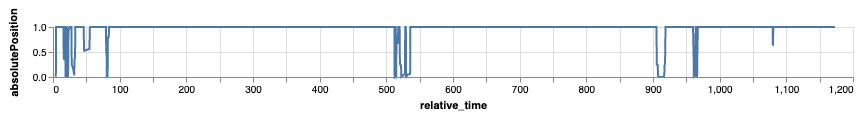

In [193]:
Vega({
    "hconcat": [
        {
            "mark": "line",
            "encoding": {
                "x": {"field": "relative_time", "type": "quantitative", "scale": {""}},
                "y": {"field": "absolutePosition", "type": "quantitative"}
            }, "width": 800, "height": 50
        },
    ]}, transitions.query("session=='1563043862065-0.hai2e1mf2xi'")
    .query("absolutePosition >= 0"))

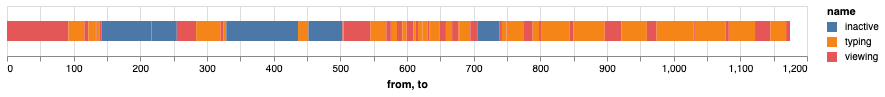

In [192]:
Vega({
    "hconcat": [
        {
            "mark": "bar",
            "encoding": {
                "x": {"field": "from", "type": "quantitative"},
                "x2": {"field": "to", "type": "quantitative"},
                "color": {"field": "name", "type": "nominal"}
            }, "width": 800, "height": 50
        },
    ]}, time_segments.query("session=='1563043862065-0.hai2e1mf2xi'"))

## Generate the plots

For each session where it makes sense, we export:

* The data of the scroll positions with their timings
* The data of the segements and their timings

This data we use in the `scrollChart.spec.vl`-file to generate a `.png` with Vega-Lite via the command line.


🛑 Attention this can take a little while to run. About 15 minutes

In [219]:
for session in transitions.query("substory != '0'").query("story != 'envelope'").session.unique():
    (transitions
         .query("session=='"+session+"'")
         .query("absolutePosition >= 0").to_csv("outputs/201907121200_scroll.csv")
    )
    (time_segments
        .query("session=='"+session+"'").to_csv("outputs/201907121200_segments.csv")
    )
    process = subprocess.Popen("vl2png \
    /Users/jonas/Desktop/P9/results/20190711_pilot_3/scrollChart.spec.vl \
    /Users/jonas/Desktop/P9/results/20190711_pilot_3/outputs/charts/"+session+".png",
                               shell=True, stdout=subprocess.PIPE)
    process.wait()

## Export

In [230]:
transitions.to_pickle("outputs/201907121200_transitions.pkl", compression="gzip")

In [231]:
transitions.columns

Index(['time', 'source', 'user', 'session', 'userAgent', 'screenWidth',
       'screenHeight', 'windowWidth', 'windowHeight', 'resolution', 'chart',
       'relativePosition', 'absolutePosition', 'message', 'story', 'substory',
       'layout', 'transition', 'condition', 'duration', 'viewing', 'typing',
       'inactive', 'WorkerId', 'code', 'has_finished', 'transitionCount',
       'session_start', 'relative_time'],
      dtype='object')